<a href="https://colab.research.google.com/github/kaiser1711/Boltzmann-machine-learning/blob/main/FVBM_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Simple fully-visible Boltzmann Machine Learning code in bipolar representation to learn a Full Adder probability distribution

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from IPython import display
import time

Parameters

In [ ]:
#Network parameters

Nv=5 #number of visible units
Nm= Nv #number of p-bits

Nsamp=int(1e3)   #sampling number of free phase

#Learning parameters
momentum=0.0 #momentum
epsilon=2**(-7)  #learning rate
epochs=1e3   #run time
weightcost=0.0; #regularization

#binary matrix
powers_of_two = 2**np.arange(Nv)[::-1]
binary=(np.arange(2**Nv)[:, np.newaxis] & powers_of_two) / powers_of_two

#dataset to learn
v=[binary[0],binary[6],binary[10],binary[13],binary[18],binary[21],binary[25],binary[31]] # Full Adder histrogram
v=2*np.vstack(v)-1
D=np.matmul(np.transpose(v),v)/8;np.fill_diagonal(D, 0);

Functions

In [ ]:
#activation function
def act(x):
    y=np.tanh(x)
    return y

#sampling (Eq.1)
def update_state(I):
    m=np.sign(act(I)+2*np.random.uniform(low=0.0, high=1.0)-1)
    return m

#synapse (Eq.2)
def get_input(W,h,m,jj):
    I=np.dot(W[jj,:],m)+h[jj]
    return I

#sampling free
def sampling_free(Nm,W,h,m,Ns):
    mm=np.zeros((Nm,Ns))
    for ii in range(0,int(Ns)):
        for jj in range(0,int(Nm)):
            I=get_input(W,h,m,jj)
            m[jj]= update_state(I)
        mm[:,ii]=m
    return mm

#get distribution from Boltzmann law
def Boltzmann_law(W,h,Nm):
    E=np.zeros((2**Nm,1))
    powers_of_two = 2**np.arange(Nm)[::-1]
    binary=(np.arange(2**Nm)[:, np.newaxis] & powers_of_two) / powers_of_two
    for ii in range(0,2**Nm):
        m=2*binary[ii]-1
        E[ii]=-np.matmul(np.transpose(m),np.matmul(W,m))/2-np.matmul(m,h)
    E=E-np.min(E)
    P=np.exp(-E)
    P=np.squeeze(P/np.sum(P))
    return P

  
#plot results
def plot_results_inline(W,h,Nm,epoch):
    P=Boltzmann_law(W,h,Nm)
    plt.style.use('ggplot')
    figa=plt.figure(figsize=(10,5))
    ax1=figa.add_subplot(111)
    ax1.bar(np.linspace(0,2**Nv-1,2**Nv), P, color='green')
    ax1.tick_params(labelsize=25)
    ax1.set_xlabel('Configuration',fontsize=30)
    ax1.set_ylabel('P(m)',fontsize=30)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(1.0)


Initialization

In [ ]:
W=0.1*np.random.normal(loc=0.0,scale=1.0,size=(Nm,Nm));np.fill_diagonal(W, 0);W=(W+np.transpose(W))/2; #initialize W randomly
Winc=np.zeros((Nm,Nm))
h=np.zeros((Nm))
hinc=np.zeros((Nm))
m=np.random.binomial(1,0.5,Nm) #initialize m

Learning

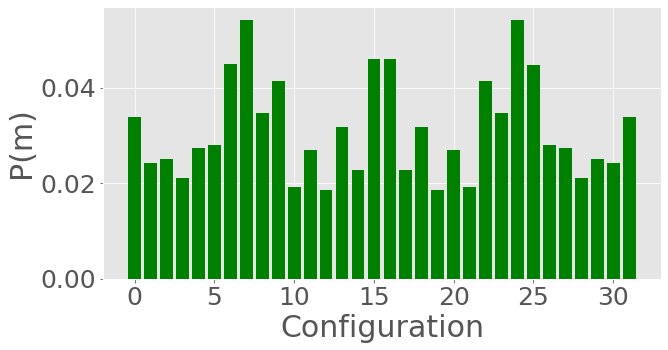

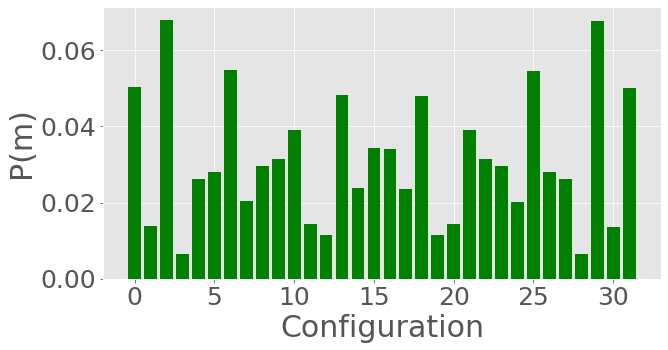

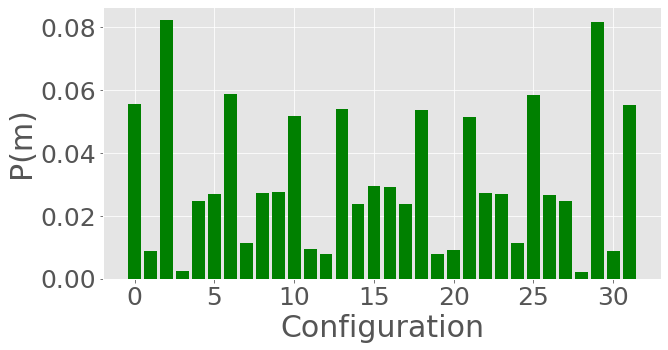

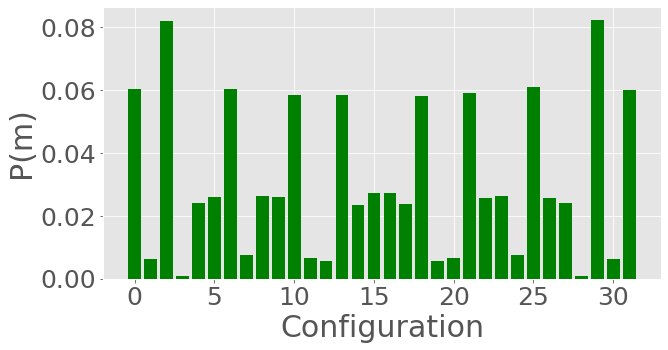

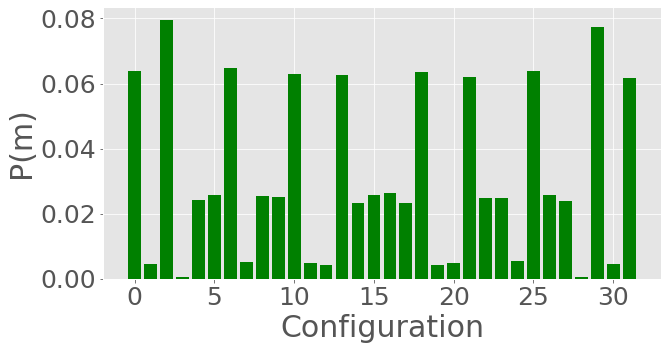

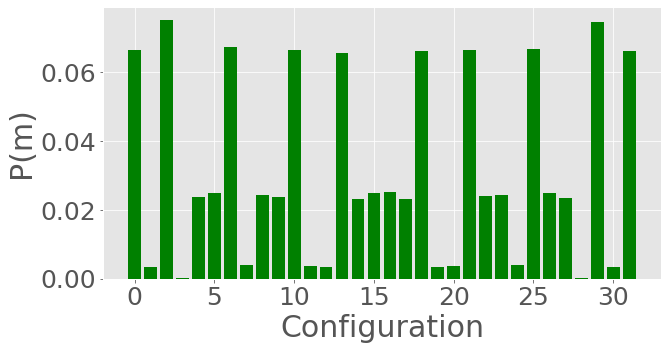

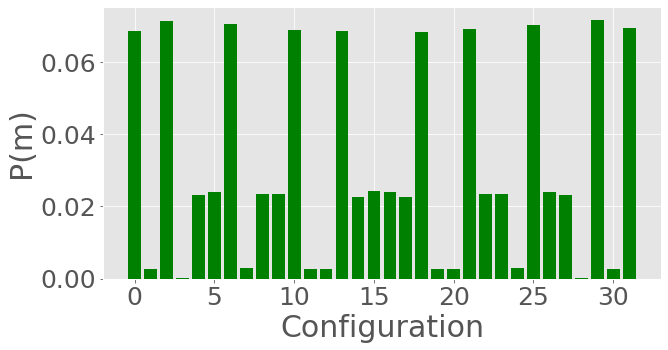

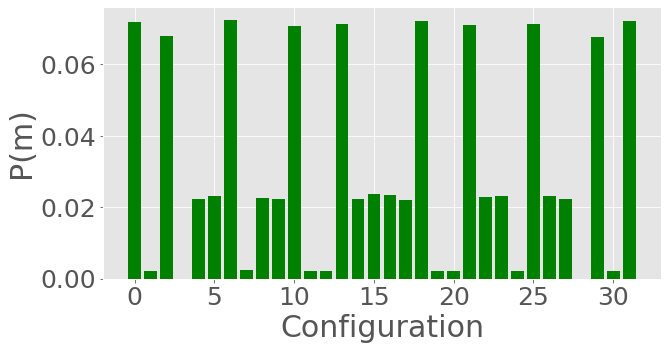

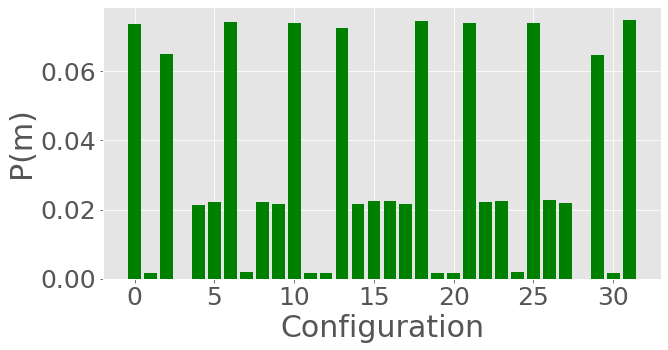

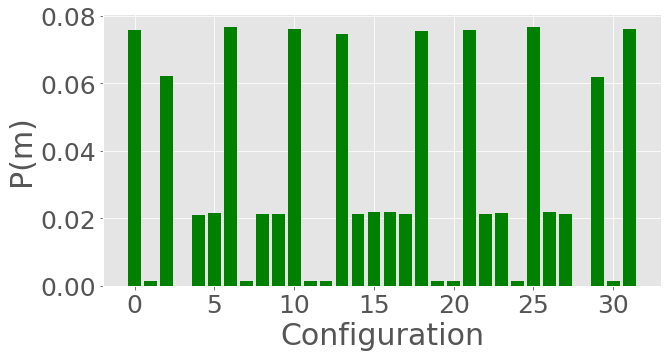

In [ ]:
for epoch in range(0,int(epochs)):

    #free phase
    mm_free=sampling_free(Nm,W,h,m,Nsamp)
    m=mm_free[:,-1]
    mimj=np.matmul(mm_free,np.transpose(mm_free))/Nsamp;np.fill_diagonal(mimj, 0);
        
    #clamped phase
    cicj=D;
    
    #bias
    hm=np.mean(mm_free,1)
    hc=np.mean(v,0)
    
    #weight update
    Winc=epsilon*(cicj-mimj-weightcost*W)+momentum*Winc;
    hinc=epsilon*(hc-hm)+momentum*hinc;

    W=W+Winc;
    h=h+hinc;
    
    if 0==np.mod(epoch,100):
        print("Epoch: " + str(epoch))
        plot_results_inline(W,h,Nm,epoch)
